# Capstone Proposal 
# Dog Breed Classifier using Convolutional Neural Networks

### Jorge Ramírez Carrasco

In this notebook, the code to train and deploy the Convolutional Neural Network to classify dog breed is presented. Additionally, a comparison in a model benchmark with other techniques and classifiers is shown and eventually the methods developed for the lambda functions.


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download and Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Download and Import Datasets

In [1]:
"""
%mkdir ../data
!wget -O ../data/dogImages.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -O ../data/lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
#!tar -zxf ../data/lfw.tgz -C ../data/
#!unzip ../data/dogImages.zip -d ../data/
"""

'\n%mkdir ../data\n!wget -O ../data/dogImages.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip\n!wget -O ../data/lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz\n#!tar -zxf ../data/lfw.tgz -C ../data/\n#!unzip ../data/dogImages.zip -d ../data/\n'

In [13]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


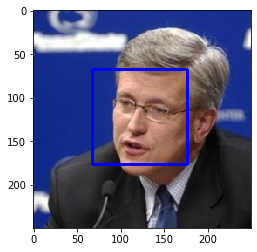

In [14]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [15]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Detecting human faces in human_files_short
 Detected 98/100 human faces
Detecting human faces in dog_files_short
 Detected 17/100 human faces

In [16]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
print("Detecting human faces in human_files_short")
human_results_short = [ face_detector(img_path) for img_path in human_files_short]
print(f" Detected {sum(human_results_short)} human faces")
print("Detecting human faces in dog_files_short")
dog_results_short = [ face_detector(img_path) for img_path in dog_files_short ]
print(f" Detected {sum(dog_results_short)} human faces")

Detecting human faces in human_files_short
 Detected 99 human faces
Detecting human faces in dog_files_short
 Detected 5 human faces


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [17]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [18]:
from PIL import Image
import torchvision.transforms as transforms
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    transform = transforms.Compose(
    [transforms.Resize(size=(256,256)),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    img = Image.open(img_path)
    if use_cuda:
        output = VGG16(transform(img).unsqueeze(0).cuda())
    else:
        output = VGG16(transform(img).unsqueeze(0))

    # position 0 return value, position 1 return indices
    return torch.max(output,1)[1].item()

VGG16_predict(dog_files_short[0])

215

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    label = VGG16_predict(img_path)
    if label > 150 and label < 269:
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Detecting human faces in human_files_short
 Detected 1% as dogs
Detecting human faces in dog_files_short
 Detected 100% as dogs


In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print("Detecting human faces in human_files_short")
human_results_short = [ dog_detector(img_path) for img_path in human_files_short]
print(f" Detected {sum(human_results_short)} dogs")
print("Detecting human faces in dog_files_short")
dog_results_short = [ dog_detector(img_path) for img_path in dog_files_short]
print(f" Detected {sum(dog_results_short)} dogs")

Detecting human faces in human_files_short
 Detected 0 dogs
Detecting human faces in dog_files_short
 Detected 99 dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 20
num_workers = 0

data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

transform_train = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

transform_valid = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])


train_set = datasets.ImageFolder(train_dir, transform=transform_train)
valid_set = datasets.ImageFolder(valid_dir, transform=transform_valid)
test_set = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: There is one common preprocessing for all datasets and some specific steps just for training. 

- First the image is resized to 224x244 as VGG16 initial layer.
- In the training transformations  a RandomHorizontalFlip, RandomVerticalFlip and RandomRotation are applied to make data augmentation. These step will add randomness and decrease overfitting while training the model.
- The image is converted into a tensor
- The values are normalized following custom datasets pytorch documentation.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    
    
    def __init__(self):
        super(Net, self).__init__()
        num_classes = len(train_set.classes)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #[batch = batch_size, channel=256, height=26, width=26]
        self.fc1 = nn.Linear(in_features=256 * 26 * 26, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ My idea was to replicate VGG-16 architecture in a simplified way removing convolution layers and keeping the 3 layers for the fully connected. 

The convolution layers will increment the number of features using a kernel size of 5 and padding 1. After each convolution there is a relu and maxpool layer with a kernel of size 2 and stride 2 reducing to the half.

After the convolution layers there is a flatten layer that creates a vector of size 256 * 26 * 26 = 173056 that links with the fully connected of 3 layers reducing the number of features until the final number of classes and applying dropout to reduce overfitting between each of them. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # initialize weights to zero
            optimizer.zero_grad()
            
            outputs = model(data)
            
            # calculate loss
            loss = criterion(outputs, target)
            
            # back propagation
            loss.backward()
            
            # gradient step
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            print('New validation loss min {:.6f}. Model saved'.format(
            valid_loss_min
            ))
                  
            
            
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.887160 	Validation Loss: 4.863676
New validation loss min 4.863676. Model saved
Epoch: 2 	Training Loss: 4.805477 	Validation Loss: 4.748628
New validation loss min 4.748628. Model saved
Epoch: 3 	Training Loss: 4.643880 	Validation Loss: 4.483684
New validation loss min 4.483684. Model saved
Epoch: 4 	Training Loss: 4.546788 	Validation Loss: 4.455003
New validation loss min 4.455003. Model saved
Epoch: 5 	Training Loss: 4.496301 	Validation Loss: 4.386619
New validation loss min 4.386619. Model saved
Epoch: 6 	Training Loss: 4.414803 	Validation Loss: 4.333554
New validation loss min 4.333554. Model saved
Epoch: 7 	Training Loss: 4.367592 	Validation Loss: 4.227906
New validation loss min 4.227906. Model saved
Epoch: 8 	Training Loss: 4.319540 	Validation Loss: 4.242622
Epoch: 9 	Training Loss: 4.246496 	Validation Loss: 4.141466
New validation loss min 4.141466. Model saved
Epoch: 10 	Training Loss: 4.203497 	Validation Loss: 4.123799
New validation loss m

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.491428


Test Accuracy: 16% (134/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Freeze parameters of the model to avoid back propagation
for param in model_transfer.parameters():
    param.requires_grad = False
    
num_classes = len(train_set.classes)

model_transfer.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=512),
                                  nn.Linear(in_features=512, out_features=256),
                                  nn.Linear(in_features=256, out_features=num_classes))

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 94781311.11it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ In this case the model architecture is downloaded from a pretrained one. First it is required to freeze the parameters already trained. Then, the last layer features and the final number of desired classes are linked by a fully connected that solves from the input features to the dog breed classes.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.750910 	Validation Loss: 1.724290
New validation loss min 1.724290. Model saved
Epoch: 2 	Training Loss: 2.001726 	Validation Loss: 1.026119
New validation loss min 1.026119. Model saved
Epoch: 3 	Training Loss: 1.671798 	Validation Loss: 0.833154
New validation loss min 0.833154. Model saved
Epoch: 4 	Training Loss: 1.516940 	Validation Loss: 0.772169
New validation loss min 0.772169. Model saved
Epoch: 5 	Training Loss: 1.451518 	Validation Loss: 0.697533
New validation loss min 0.697533. Model saved
Epoch: 6 	Training Loss: 1.386428 	Validation Loss: 0.787076
Epoch: 7 	Training Loss: 1.292601 	Validation Loss: 0.734385
Epoch: 8 	Training Loss: 1.263273 	Validation Loss: 0.757700
Epoch: 9 	Training Loss: 1.231691 	Validation Loss: 0.758337
Epoch: 10 	Training Loss: 1.215005 	Validation Loss: 0.720388


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [20]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.681177


Test Accuracy: 78% (655/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [21]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    transform = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    
    
    img = Image.open(img_path)
    if use_cuda:
        output = model_transfer(transform(img).unsqueeze(0).cuda())
    else:
        output = model_transfer(transform(img).unsqueeze(0))

    
    # position 0 return value, position 1 return indices
    output_index = torch.max(output,1)[1].item()
    return class_names[output_index]
predict_breed_transfer(dog_files_short[0])

'Bullmastiff'

### 

---
<a id='step5'></a>
## Step 5: Compare with Classical Machine Learning Classification Algorithms: SVM and Logistic Regression

In the next cells we will transform the dataset into a pandas dataframe with pixel information in the image on each column and train using classical Machine Learning classification algorithms like SVM or Logistic Regression

In [22]:
from sklearn import datasets, svm, metrics
import pandas as pd


def create_df_from_dir(ds_dir):
    images = []
    data = []
    transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)),
     transforms.Grayscale(num_output_channels = 1),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5],
                                 std=[0.5])])
    for path, subdirs, files in os.walk(ds_dir):
        files = [path+"/"+file for file in files]
        images += files
    for img in images:
        img = Image.open(img)
        data.append(transform(img).data.numpy()[0,:,:].flatten() )
    labels = [int(path.split("/")[-2].split(".")[0]) for path in images]
    df_dict = {'data':data, 'target':labels}    
    return pd.DataFrame(df_dict)

train_df = create_df_from_dir(train_dir)
val_df = create_df_from_dir(valid_dir)
test_df = create_df_from_dir(test_dir)

X_train = train_df.data.apply(pd.Series)
y_train = train_df['target']
X_test = test_df.data.apply(pd.Series)
y_test = test_df['target']


In [23]:
# Create a classifier: a support vector machine classifier
classifier = svm.SVC(gamma=0.001)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)


In [24]:
print("Classification report for classifier {} {:.2f}%".format(classifier, metrics.accuracy_score(y_test, y_pred)*100))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 6.10%


In [26]:
from sklearn.linear_model import LogisticRegression
# Create a classifier: a support vector machine classifier
classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)


In [27]:
print("Classification report for classifier {} {:.2f}%".format(classifier, metrics.accuracy_score(y_test, y_pred)*100))

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 2.87%


---
<a id='step6'></a>
## Step 6: Model Benchmark

In this section, we will compare the different performance to select the best model.

---
<a id='step7'></a>
## Step 7: SageMaker Model Training & Deployment

In this section, we will train the selected candidate using AWS SageMaker training capabilities and deploy it to include this model in a complete application.

### Upload the data to S3

In [3]:
import pandas as pd
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# should be the name of directory you created to save your features data
data_dir ='/home/ec2-user/SageMaker/data/dogImages'

# set prefix, a descriptive name for a directory  
prefix = 'capstone-project-dog-breed-classifier'

# upload all data to S3
sagemaker_session.upload_data(data_dir, key_prefix=prefix)

### Train Model

In [4]:
# your import and estimator code, here
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="models/cnn_pytorch",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.4xlarge',
                    hyperparameters={
                        'epochs': 15
                    })

In [5]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': 's3://sagemaker-eu-central-1-411771656960/capstone-project-dog-breed-classifier'})
#estimator = estimator.attach(training_job_name='sagemaker-pytorch-2020-09-10-17-15-08-953')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-11 09:11:53 Starting - Starting the training job...
2020-09-11 09:11:55 Starting - Launching requested ML instances......
2020-09-11 09:13:09 Starting - Preparing the instances for training......
2020-09-11 09:14:08 Downloading - Downloading input data.........
2020-09-11 09:15:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-09-11 09:15:45,996 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-09-11 09:15:45,998 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-11 09:15:46,009 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-09-11 09:15:47,449 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-09-11 09:15:47,795 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating

### Deploy Model

In [6]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image, ImageFile
from torchvision import datasets
from torchvision.transforms import ToTensor
import os

batch_size=20


test_dir = os.path.join(data_dir, 'test/')

transform = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

test_set = datasets.ImageFolder(test_dir, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False)



In [8]:
def test_sagemaker_endpoint(loader, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.from_numpy(predictor.predict(data))
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test_sagemaker_endpoint(test_loader, nn.CrossEntropyLoss(), False)

Test Loss: 0.657677


Test Accuracy: 81% (681/836)


In [10]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in test_loader.dataset.classes]

def predict_breed_sagemaker_transfer(img_path):
    # load the image and return the predicted breed
    transform = transforms.Compose(
    [transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    
    img = Image.open(img_path)
    output = torch.from_numpy(predictor.predict(transform(img).unsqueeze(0)))   
    # position 0 return value, position 1 return indices
    output_index = torch.max(output,1)[1].item()
    return class_names[output_index]

predict_breed_sagemaker_transfer('images/Labrador_retriever_06457.jpg')


'Labrador retriever'

In [22]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


---
<a id='step8'></a>
## Step 8: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [11]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_sagemaker_transfer(img_path)
        print("Dogs Detected!\nIt looks like a {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_sagemaker_transfer(img_path)
        print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
    else:
        print("Error! Can't detect anything..")

---
<a id='step9'></a>
## Step 9: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

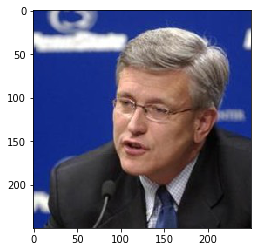

Hello, human!
If you were a dog..You may look like a Norwegian lundehund


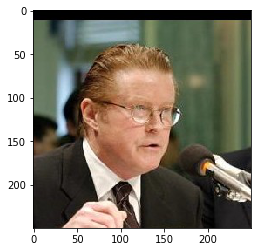

Hello, human!
If you were a dog..You may look like a Norwegian lundehund


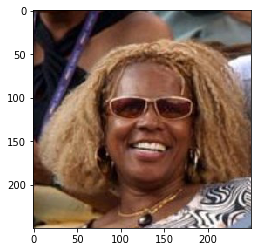

Hello, human!
If you were a dog..You may look like a Pharaoh hound


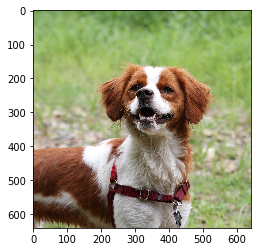

Dogs Detected!
It looks like a Brittany


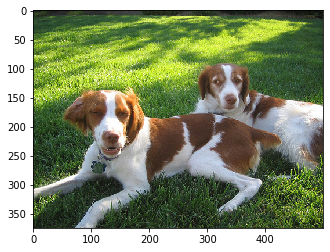

Dogs Detected!
It looks like a Brittany


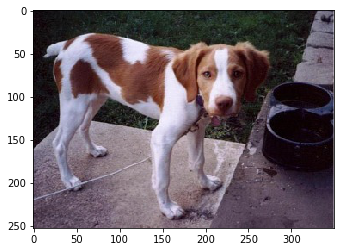

Dogs Detected!
It looks like a Brittany


In [21]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)